In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
from dataclasses import dataclass
from matplotlib import pyplot as plt

def dot(a, b, **kwargs):
    return np.multiply(a, b).sum(axis=-2, **kwargs)

def make_vec3(x, y, z):
    return np.array((x, y, z)).reshape(3, 1)

@dataclass
class SG:
    axis: np.ndarray
    amplitude: np.ndarray
    sharpness: np.ndarray

    def eval(self, v):
        r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis, keepdims=True) - 1))
        s = r.sum(axis=(0, 1))
        return s

    def jac(self, v):
        f = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis, keepdims=True) - 1))
        d_axis = f * self.sharpness * v
        d_amp = f / self.amplitude
        d_sh = f * (dot(v, self.axis, keepdims=True) - 1)
        j = np.concatenate((d_axis, d_amp, d_sh), axis=1)
        return j

def polar_to_r3(phi, axis=0):
    phi = phi if len(np.shape(phi)) > 0 else np.reshape(phi, 1)
    p = np.stack((np.cos(phi), np.zeros(np.shape(phi)), np.sin(phi)), axis=axis)
    return p

def polar_to_r3_diff(phi, axis=0):
    phi = phi if len(np.shape(phi)) > 0 else np.reshape(phi, 1)
    p = np.stack((-np.sin(phi), np.zeros(np.shape(phi)), np.cos(phi)), axis=axis)
    return p

def newton(f, df, x0, n):
    xp = x0
    x = x0
    for i in range(n):
        x = xp - f(xp) / df(xp)
        xp = x
    return x

def F_schlick(f0, NoL):
    return f0 + (1 - f0) * (1 - NoL) ** 5

def G_smith(alpha, NoV, NoL):
    alpha2 = alpha ** 2;
    NoV2 = NoV ** 2
    NoL2 = NoL ** 2
    A_V = np.sqrt(1 + alpha2 * (1 - NoV2) / NoV2)
    A_L = np.sqrt(1 + alpha2 * (1 - NoL2) / NoL2)
    return 2 / (A_V + A_L)

def D_ggx(alpha, NoH):
    alpha2 = alpha ** 2
    return alpha2 / (np.pi * (1 + NoH ** 2 * (alpha2 - 1)) ** 2)

def BRDF(f0, alpha, N, V, L, mul_NoL=False):
    H = L + V
    H = H / np.linalg.norm(H, axis=0)
    HoV = dot(V, H)
    NoV = dot(N, V)
    NoL = dot(N, L)
    NoH = dot(N, H)
    F = F_schlick(f0, HoV)
    G = G_smith(alpha, NoV, NoL)
    D = D_ggx(alpha, NoH)
    if mul_NoL:
        return np.where(NoL > 0, F * G * D / (4 * NoV), 0)
    return np.where(NoL > 0, F * G * D / (4 * NoV * NoL), 0)

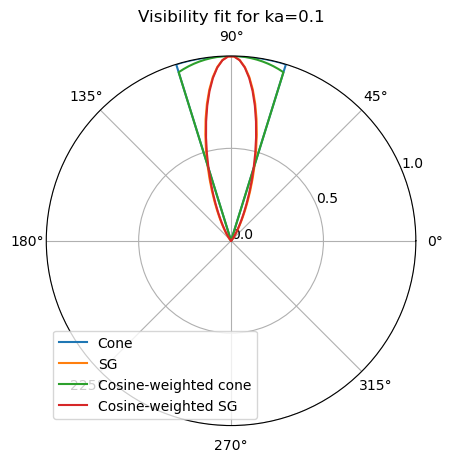

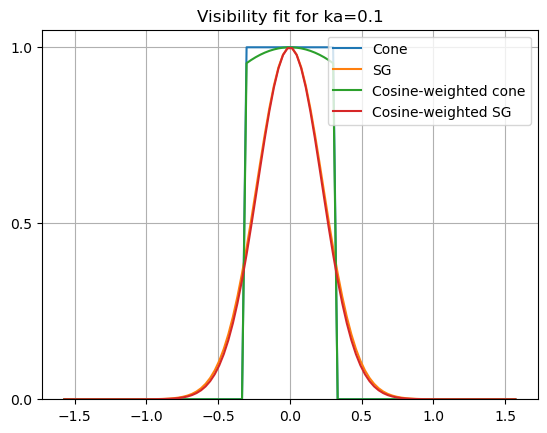

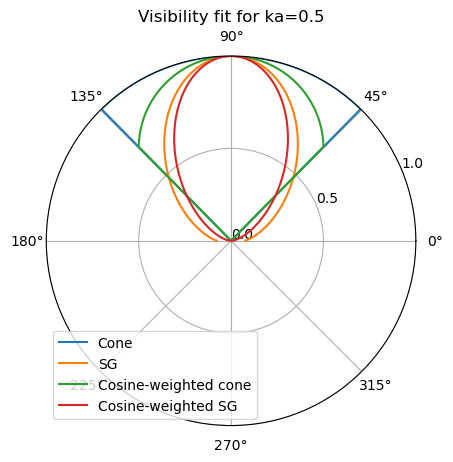

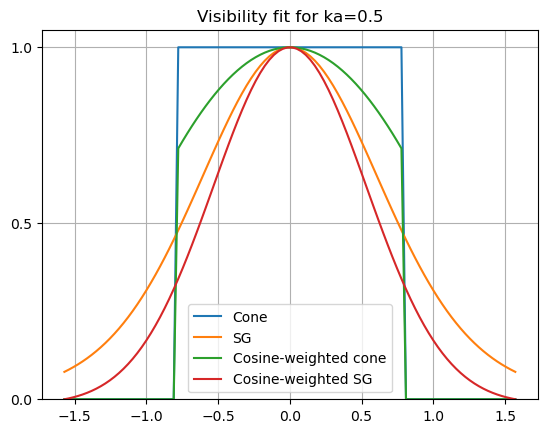

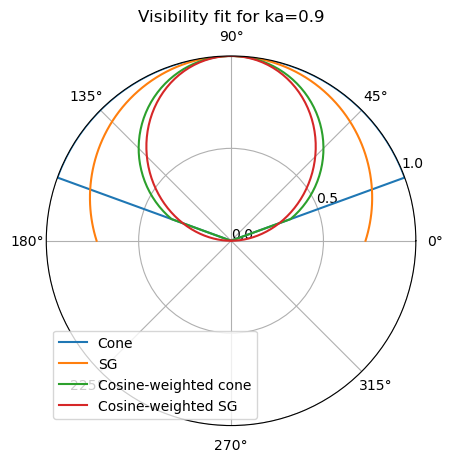

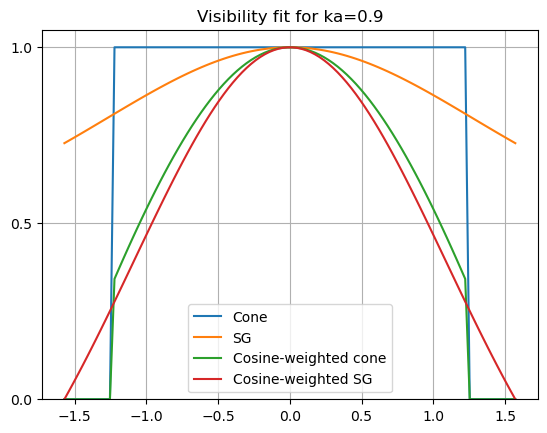

In [2]:
# Fit visibility SG

@dataclass
class Cone:
    axis: np.ndarray
    aperture: np.ndarray

    def eval(self, v):
        return np.where(dot(v, self.axis) > np.cos(self.aperture), 1.0, 0.0)

def ka_from_lambda(l):
    return 2.0 * (l + np.exp(-l) - 1.0) / (l * l)

def ka_from_lambda_diff(l):
    return -2.0 * (l - 2.0 + np.exp(-l) * (l + 2.0)) / (l * l * l)

def l0_from_ka(ka):
    return 2.0 / (ka + 0.01) * (1.0 - ka) + 3.0 * (1.0 - ka) * ka

for ka in (0.1, 0.5, 0.9):
    N = make_vec3(0, 0, 1)
    
    l0 = l0_from_ka(ka)
    l1 = newton(lambda l: ka_from_lambda(l) - ka, ka_from_lambda_diff, l0, 1)
    sg = SG(np.reshape(N, (1, 3, 1)), np.reshape(1, (1, 1, 1)), np.reshape(l1, (1, 1, 1)))

    aperture = np.acos(np.sqrt(1.0 - ka))
    c = Cone(N, aperture)

    phi = np.linspace(0, np.pi, num=100)
    axis = polar_to_r3(phi)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    plt.title(f"Visibility fit for ka={ka}")
    ax.plot(phi, c.eval(axis), label=f"Cone")
    ax.plot(phi, sg.eval(axis), label=f"SG")
    ax.plot(phi, c.eval(axis) * np.sin(phi), label = f"Cosine-weighted cone")
    ax.plot(phi, sg.eval(axis) * np.sin(phi), label = f"Cosine-weighted SG")
    ax.set_rmax(1)
    ax.set_rticks([0.0, 0.5, 1])
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"Visibility fit for ka={ka}")
    ax.plot(phi - np.pi / 2.0, c.eval(axis), label=f"Cone")
    ax.plot(phi - np.pi / 2.0, sg.eval(axis), label=f"SG")
    ax.plot(phi - np.pi / 2.0, c.eval(axis) * np.sin(phi), label = f"Cosine-weighted cone")
    ax.plot(phi - np.pi / 2.0, sg.eval(axis) * np.sin(phi), label = f"Cosine-weighted SG")
    ax.set_ylim(1)
    ax.set_yticks([0.0, 0.5, 1])
    ax.grid(True)
    ax.legend()
    plt.show()

Fit 1 SG(s):
Optimal parameters:
[[ 3108.96827077 19795.24429758]]
CN: inf
Sigma^2:
[[1.57641732e+17 1.02938563e+18]]
Sigma:
[[3.97041222e+08 1.01458643e+09]]
Epsilon:
[[127708.35457662  51254.04967665]]

Fit 2 SG(s):
Optimal parameters:
[[ 1554.21851426 19793.88769558]
 [ 1554.21851426 19793.88769558]]
CN: 4.012816656277353e+32
Sigma^2:
[[4.01080365e+16 1.04796488e+18]
 [4.01080365e+16 1.04796488e+18]]
Sigma:
[[2.00269909e+08 1.02370156e+09]
 [2.00269909e+08 1.02370156e+09]]
Epsilon:
[[128855.69653764  51718.06444141]
 [128855.69653763  51718.06444141]]



/tmp/ipykernel_40090/2120307136.py:20: RuntimeWarning: overflow encountered in exp
  r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis, keepdims=True) - 1))


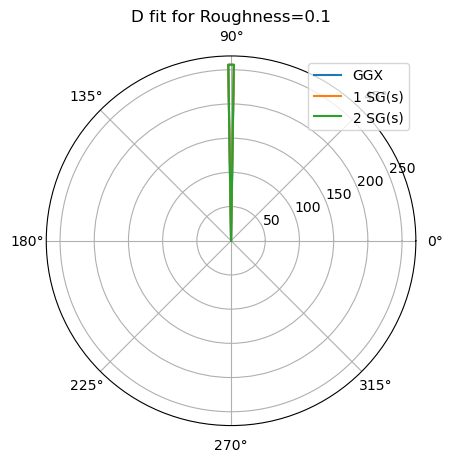

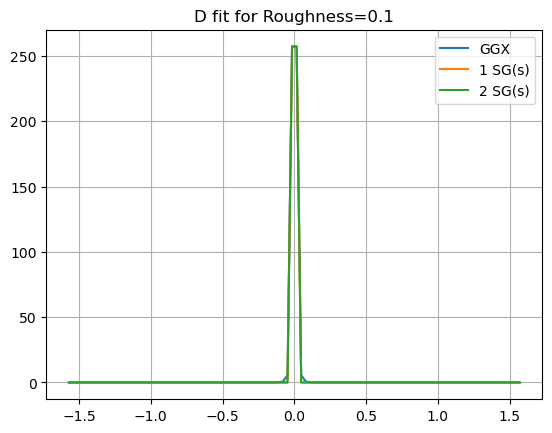

Fit 1 SG(s):
Optimal parameters:
[[ 4.82090206 39.4349011 ]]
CN: 532.8617765324533
Sigma^2:
[[0.00276867 0.98170514]]
Sigma:
[[0.05261814 0.99081034]]
Epsilon:
[[0.01091458 0.02512521]]

Fit 2 SG(s):
Optimal parameters:
[[ 3.75480908 67.28714829]
 [ 1.29033649 12.35910016]]
CN: 54600.28571516968
Sigma^2:
[[0.00333414 1.93621552]
 [0.00362422 0.23187971]]
Sigma:
[[0.05774202 1.39147962]
 [0.06020149 0.48153889]]
Epsilon:
[[0.01537815 0.02067972]
 [0.04665565 0.03896229]]



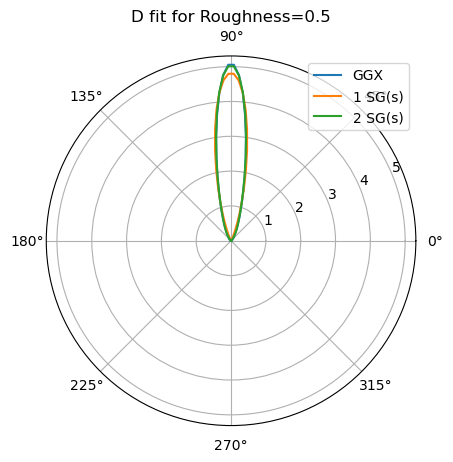

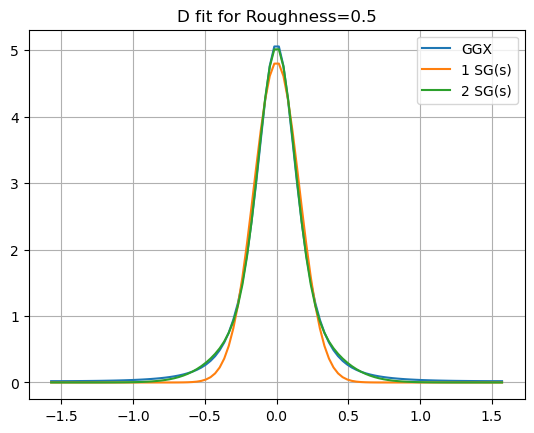

Fit 1 SG(s):
Optimal parameters:
[[0.45400082 1.05688532]]
CN: 87.77175811573
Sigma^2:
[[1.74983818e-05 8.61313272e-04]]
Sigma:
[[0.00418311 0.02934814]]
Epsilon:
[[0.00921387 0.02776852]]

Fit 2 SG(s):
Optimal parameters:
[[2.88104911e-01 3.36475807e+00]
 [1.96247223e-01 1.29304435e-15]]
CN: 235251.22335980047
Sigma^2:
[[7.09238868e-06 1.12330432e-03]
 [7.53516928e-06 1.68874522e-04]]
Sigma:
[[0.00266315 0.03351573]
 [0.00274503 0.01299517]]
Epsilon:
[[9.24369491e-03 9.96081492e-03]
 [1.39875930e-02 1.00500598e+13]]



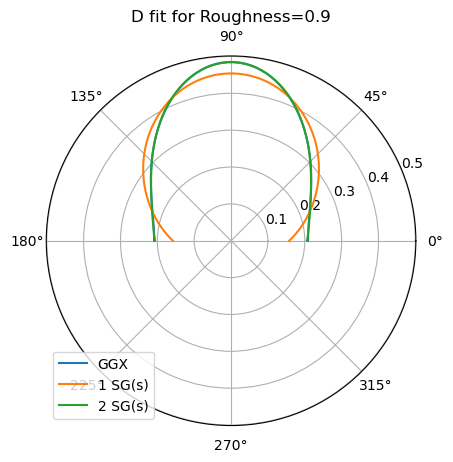

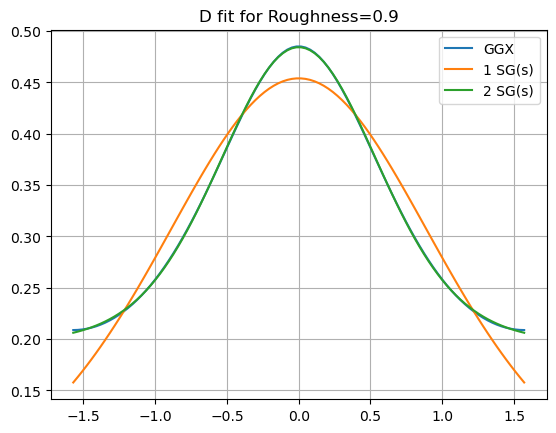

In [3]:
# Fit normal distribution SG

for roughness in (0.1, 0.5, 0.9):
    N = make_vec3(0, 0, 1)
    
    alpha = roughness ** 2
    alpha2 = alpha ** 2

    phi = np.linspace(0, np.pi, num=100)
    H = polar_to_r3(phi)
    d = D_ggx(alpha, dot(N, H))

    def eval_ggx_sg(phi, *args):
        args = np.array(args).reshape(-1, 2, 1)
        
        amp = args[:, 0]
        sh = args[:, 1]
        axis = np.full(amp.shape, np.pi / 2)
        
        return SG(polar_to_r3(axis, axis=1), np.expand_dims(amp, -1), np.expand_dims(sh, -1)).eval(polar_to_r3(phi))

    def jac_ggx_sg(phi, *args):
        v = polar_to_r3(phi)
        args = np.array(args).reshape(-1, 2, 1)
        
        amp = args[:, 0]
        sh = args[:, 1]
        u = polar_to_r3(np.full(amp.shape, np.pi / 2), axis=1)
        sg = SG(u, np.expand_dims(amp, -1), np.expand_dims(sh, -1))
        
        j = sg.jac(v)
        j = np.vstack(j[:,3:]).transpose()

        return j

    d_sgs = []

    for i in range(2):
        k = i + 1
        try:
            p0 = np.tile((1 / (np.pi * alpha2 * k), 2 / alpha2), k)
            p0, _ = sp.optimize.curve_fit(eval_ggx_sg, phi, d, p0=p0, jac=jac_ggx_sg)
            scale = 1 / np.abs(p0)
            lb = np.tile((-np.inf, 0.0), k)
            ub = np.tile((np.inf, np.inf), k)
            p0 = np.clip(p0, lb, ub)
            popt, pcov = sp.optimize.curve_fit(eval_ggx_sg, phi, d, p0=p0, bounds=(lb, ub), x_scale=scale, jac=jac_ggx_sg)
            print(f"Fit {k} SG(s):")
            print("Optimal parameters:\n{}".format(popt.reshape(-1, 2)))
            print("CN: {}".format(np.linalg.cond(pcov)))
            sigma_2 = np.diag(pcov).reshape(-1, 2)
            sigma = np.sqrt(sigma_2)
            eps = np.abs(sigma / popt.reshape(-1, 2))
            print(f"Sigma^2:\n{sigma_2}")
            print(f"Sigma:\n{sigma}")
            print(f"Epsilon:\n{eps}")
            print("")
            d_sgs.append(popt)
        except RuntimeError:
            break

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    plt.title(f"D fit for Roughness={roughness}")
    ax.plot(phi, d, label="GGX")
    for i, d_sg in enumerate(d_sgs):
        k = i + 1
        ax.plot(phi, eval_ggx_sg(phi, d_sg), label=f"{k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"D fit for Roughness={roughness}")
    ax.plot(phi - np.pi / 2.0, d, label="GGX")
    for i, d_sg in enumerate(d_sgs):
        k = i + 1
        ax.plot(phi - np.pi / 2.0, eval_ggx_sg(phi, d_sg), label=f"{k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

Fit 2 SG(s):
Optimal parameters:
[[7.79602857e-01 1.80283051e+02 2.10758562e+04]
 [7.79602857e-01 1.80283051e+02 2.10758562e+04]]
CN: 2.102861672592675e+30
Sigma^2:
[[6.21245076e+30 4.95856399e+39 5.60255142e+43]
 [6.21245076e+30 4.95856399e+39 5.60255142e+43]]
Sigma:
[[2.49247884e+15 7.04170717e+19 7.48501932e+21]
 [2.49247884e+15 7.04170717e+19 7.48501932e+21]]
Epsilon:
[[3.19711353e+15 3.90591747e+17 3.55146630e+17]
 [3.19711353e+15 3.90591747e+17 3.55146630e+17]]

Fit 3 SG(s):
Optimal parameters:
[[7.79799943e-01 1.80802438e-01 1.80279609e+02]
 [7.87106270e-01 5.12162400e+01 5.32262555e+03]
 [7.83079235e-01 3.27132922e+00 9.93499805e+02]]
CN: 1830066178432653.5
Sigma^2:
[[7.43206866e-07 2.31518099e-04 9.34065960e+01]
 [7.48998941e-10 2.53673251e-03 9.08092900e+02]
 [2.82825099e-08 8.94906928e-03 5.13198572e+02]]
Sigma:
[[8.62094465e-04 1.52157188e-02 9.66470879e+00]
 [2.73678450e-05 5.03659857e-02 3.01345798e+01]
 [1.68174046e-04 9.45995205e-02 2.26538865e+01]]
Epsilon:
[[1.1055328

/tmp/ipykernel_40090/2120307136.py:20: RuntimeWarning: overflow encountered in exp
  r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis, keepdims=True) - 1))
/usr/lib/python3.13/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


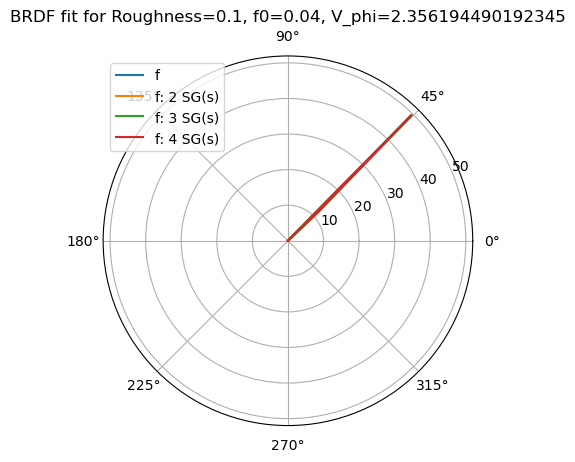

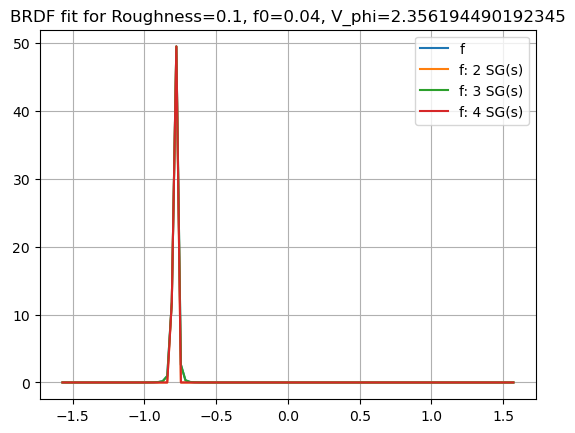

Fit 2 SG(s):
Optimal parameters:
[[ 0.69439976  0.09782055 10.27288567]
 [-1.10011386  1.47594532  3.98794158]]
CN: 702728.8545419764
Sigma^2:
[[3.08540944e-05 1.33460947e-06 8.74482926e-02]
 [7.39510368e-04 4.60251805e-02 1.75222997e-02]]
Sigma:
[[0.00555465 0.00115525 0.29571657]
 [0.02719394 0.2145348  0.13237182]]
Epsilon:
[[0.00799921 0.01180992 0.02878613]
 [0.0247192  0.14535417 0.03319302]]

Fit 3 SG(s):
Optimal parameters:
[[ -0.43077258 -33.72597192   4.19988649]
 [  0.75384463   0.05205291  19.38156077]
 [ -0.44182722  34.4257276    4.12942197]]
CN: 2.9113069187686077e+18
Sigma^2:
[[5.23376374e+00 1.84648672e+08 2.09068252e+02]
 [3.96156368e-05 1.34843354e-05 7.96385235e-01]
 [4.49666965e+00 1.84654230e+08 1.86529074e+02]]
Sigma:
[[2.28774206e+00 1.35885493e+04 1.44591926e+01]
 [6.29409539e-03 3.67210232e-03 8.92404188e-01]
 [2.12053523e+00 1.35887538e+04 1.36575647e+01]]
Epsilon:
[[5.31078846e+00 4.02910532e+02 3.44275796e+00]
 [8.34932710e-03 7.05455724e-02 4.60439796e-02]

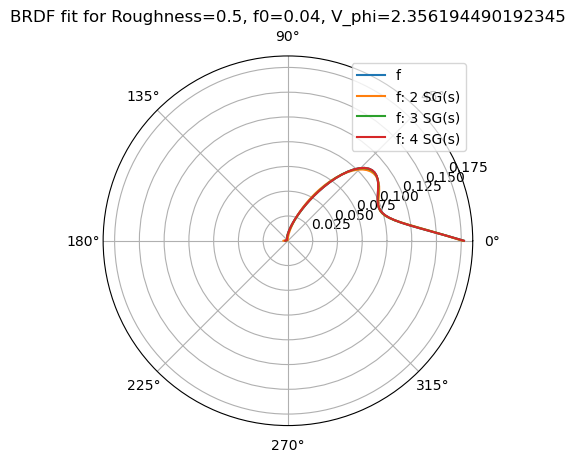

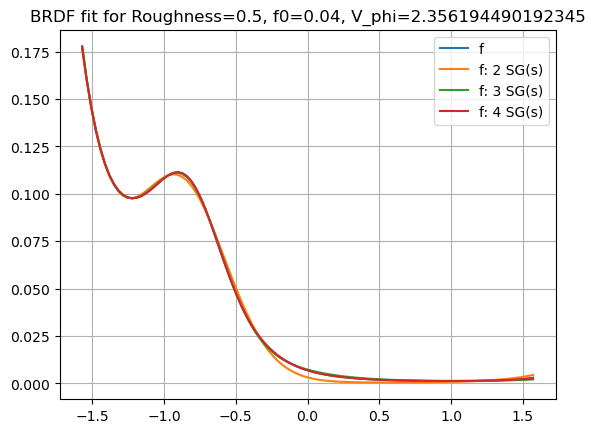

Fit 2 SG(s):
Optimal parameters:
[[ -0.59504616 -30.18543287   2.23576423]
 [ -0.59835089  30.35590815   2.23181345]]
CN: 5.032521120569232e+20
Sigma^2:
[[3.43031158e+02 1.14312872e+11 4.92509823e+02]
 [3.39649475e+02 1.14312881e+11 4.83222716e+02]]
Sigma:
[[1.85211003e+01 3.38101867e+05 2.21925623e+01]
 [1.84295815e+01 3.38101879e+05 2.19823274e+01]]
Epsilon:
[[3.11254850e+01 1.12008288e+04 9.92616397e+00]
 [3.08006250e+01 1.11379267e+04 9.84953622e+00]]

Fit 3 SG(s):
Optimal parameters:
[[-2.95652026e-01  2.66647827e+03  2.64666049e+00]
 [-2.92061655e-01 -5.35315181e+03  2.65379612e+00]
 [-2.88562581e-01  2.68687967e+03  2.66080922e+00]]
CN: 2.6030266034972802e+28
Sigma^2:
[[3.71365257e+07 1.84950037e+20 1.45438346e+08]
 [1.53224702e+08 7.06212051e+17 6.10408329e+08]
 [3.94932949e+07 2.08503282e+20 1.59977026e+08]]
Sigma:
[[6.09397454e+03 1.35996337e+10 1.20597822e+04]
 [1.23783966e+04 8.40364237e+08 2.47064431e+04]
 [6.28436909e+03 1.44396427e+10 1.26482025e+04]]
Epsilon:
[[2.061198

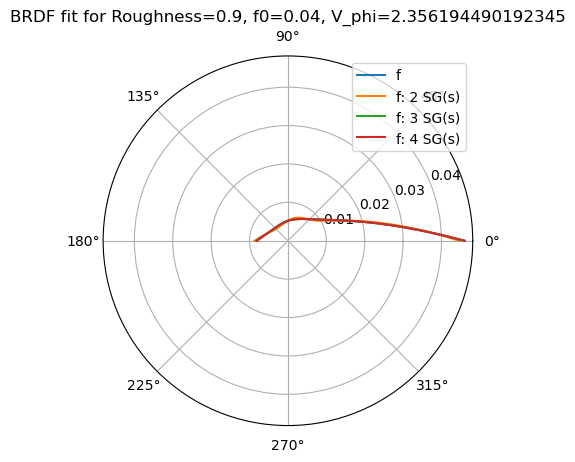

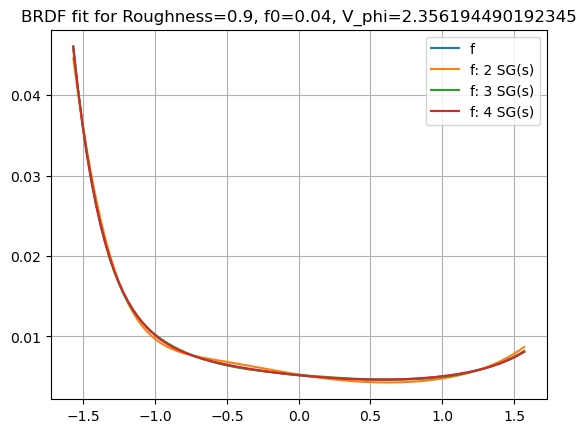

In [4]:
# Fit BRDF SG

for roughness in (0.1, 0.5, 0.9):
    f0 = 0.04
    alpha = roughness ** 2
    alpha2 = alpha ** 2

    N_phi = np.pi / 2
    V_phi = 3 * np.pi / 4
    R_phi = 2 * N_phi - V_phi
    N = polar_to_r3(N_phi)
    V = polar_to_r3(V_phi)

    phi = np.linspace(0, np.pi, num=100)
    L = polar_to_r3(phi)
    f = BRDF(f0, alpha, N, V, L)

    def eval_brdf_sg(phi, *args):
        args = np.array(args).reshape(-1, 3, 1)
        axis = args[:, 0]
        amp = args[:, 1]
        sh = args[:, 2]
        return SG(polar_to_r3(axis, axis=1), np.expand_dims(amp, -1), np.expand_dims(sh, -1)).eval(polar_to_r3(phi))
  
    def jac_brdf_sg(phi, *args):
        v = polar_to_r3(phi)
        args = np.array(args).reshape(-1, 3, 1)

        axis = args[:, 0]
        amp = args[:, 1]
        sh = args[:, 2]
        u = polar_to_r3(axis, axis=1)
        sg = SG(u, np.expand_dims(amp, -1), np.expand_dims(sh, -1))
        
        du = polar_to_r3_diff(axis, axis=1)
        
        j = sg.jac(v)
        du = dot(du, j[:, :3], keepdims=True)
        j = np.concatenate((du, j[:, 3:]), axis=1)
        j = np.vstack(j).transpose()

        return j

    brdf_sgs = []

    MIN_SG = 2
    MAX_SG = 4

    for k in range(MIN_SG, MAX_SG + 1):
        try:
            p0 = np.tile((R_phi, 1 / (np.pi * alpha2 * k), 2 / alpha2), k)
            popt, pcov = sp.optimize.curve_fit(eval_brdf_sg, phi, f, p0=p0, jac=jac_brdf_sg, maxfev=10_000)
            print(f"Fit {k} SG(s):")
            print("Optimal parameters:\n{}".format(popt.reshape(-1, 3)))
            print("CN: {}".format(np.linalg.cond(pcov)))
            sigma_2 = np.diag(pcov).reshape(-1, 3)
            sigma = np.sqrt(sigma_2)
            eps = np.abs(sigma / popt.reshape(-1, 3))
            print(f"Sigma^2:\n{sigma_2}")
            print(f"Sigma:\n{sigma}")
            print(f"Epsilon:\n{eps}")
            print("")
            brdf_sgs.append(popt)
        except RuntimeError:
            break

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    plt.title(f"BRDF fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
    ax.plot(phi, f, label="f")
    for k, brdf_sg in enumerate(brdf_sgs, start=MIN_SG):
        ax.plot(phi, eval_brdf_sg(phi, brdf_sg), label=f"f: {k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"BRDF fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
    ax.plot(phi - np.pi / 2, f, label="f")
    for k, brdf_sg in enumerate(brdf_sgs, start=MIN_SG):
        ax.plot(phi - np.pi / 2, eval_brdf_sg(phi, brdf_sg), label=f"f: {k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

/tmp/ipykernel_40382/2120307136.py:20: RuntimeWarning: overflow encountered in exp
  r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis, keepdims=True) - 1))
/tmp/ipykernel_40382/3933070615.py:52: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = sp.optimize.curve_fit(eval_brdf_sg, phi, f_NoL, p0=p0, jac=jac_brdf_sg, maxfev=10_000)


Fit 2 SG(s):
Optimal parameters:
[[7.91892285e-01 2.20588773e+02 2.42315895e+04]
 [7.91892285e-01 2.20588773e+02 2.42315895e+04]]
Sigma^2:
[[inf inf inf]
 [inf inf inf]]
Sigma:
[[inf inf inf]
 [inf inf inf]]
Epsilon:
[[inf inf inf]
 [inf inf inf]]

Fit 3 SG(s):
Optimal parameters:
[[7.91889387e-01 1.47106760e+02 2.42444362e+04]
 [7.91889387e-01 1.47106760e+02 2.42444362e+04]
 [7.91889387e-01 1.47106760e+02 2.42444362e+04]]
Sigma^2:
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]
Sigma:
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]
Epsilon:
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]

Fit 4 SG(s):
Optimal parameters:
[[7.91887413e-01 1.10596572e+02 2.42742679e+04]
 [7.91887413e-01 1.10596572e+02 2.42742679e+04]
 [7.91887413e-01 1.10596572e+02 2.42742679e+04]
 [7.91887413e-01 1.10596572e+02 2.42742679e+04]]
Sigma^2:
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]
 [inf inf inf]]
Sigma:
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]
 [inf inf inf]]
Epsilon:
[[inf inf inf]
 [inf inf inf]
 [inf 

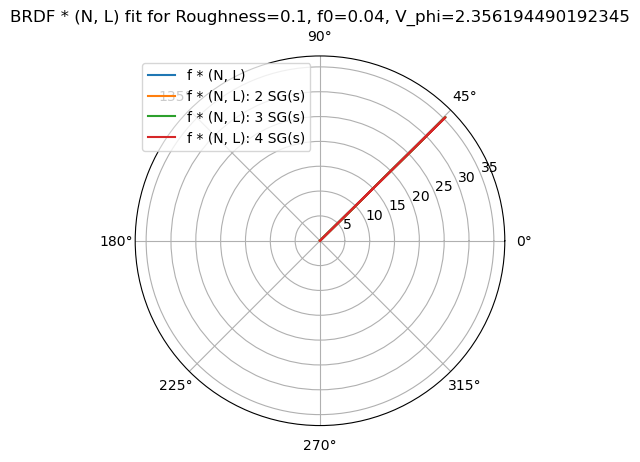

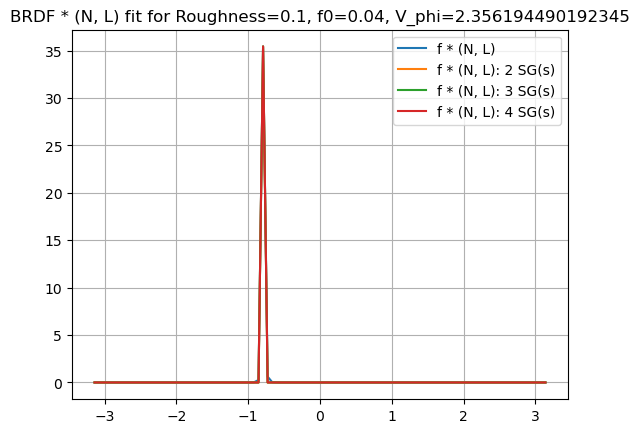

/tmp/ipykernel_40382/2120307136.py:20: RuntimeWarning: overflow encountered in multiply
  r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis, keepdims=True) - 1))


Fit 2 SG(s):
Optimal parameters:
[[7.85363786e-01 1.16695073e-02 5.53776889e+01]
 [7.48865368e-01 6.25011142e-02 8.11469199e+00]]
Sigma^2:
[[1.75036721e-04 5.80958469e-06 3.51982741e+02]
 [1.79893836e-05 6.20572677e-06 9.40975048e-02]]
Sigma:
[[1.32301444e-02 2.41030801e-03 1.87612031e+01]
 [4.24138935e-03 2.49112962e-03 3.06753166e-01]]
Epsilon:
[[0.01684588 0.20654754 0.33878631]
 [0.00566375 0.03985736 0.03780219]]

Fit 3 SG(s):
Optimal parameters:
[[8.21400844e-01 1.07739845e-02 5.34682984e+01]
 [7.25446191e-01 6.23907149e-02 9.17264936e+00]
 [1.42913242e+00 4.16928604e-03 4.28321731e+00]]
Sigma^2:
[[2.21759000e-04 4.71469505e-06 2.57712411e+02]
 [2.83747929e-04 2.64483613e-05 2.84536482e-01]
 [2.35848386e-01 5.32656896e-06 1.20865504e+01]]
Sigma:
[[1.48915748e-02 2.17133486e-03 1.60534237e+01]
 [1.68448191e-02 5.14279703e-03 5.33419612e-01]
 [4.85642241e-01 2.30793608e-03 3.47657165e+00]]
Epsilon:
[[0.01812949 0.20153499 0.3002419 ]
 [0.02321994 0.08242888 0.05815328]
 [0.33981612

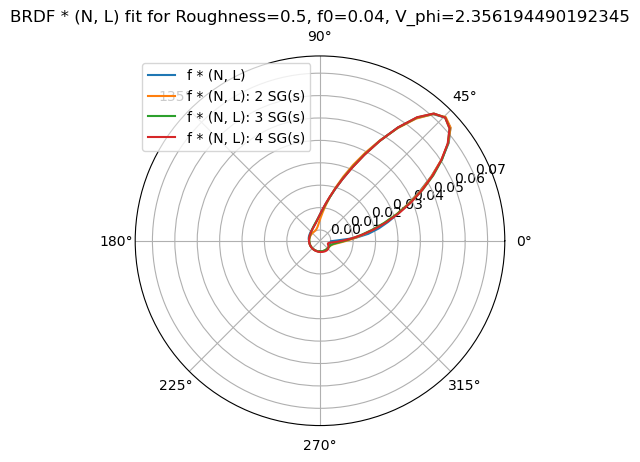

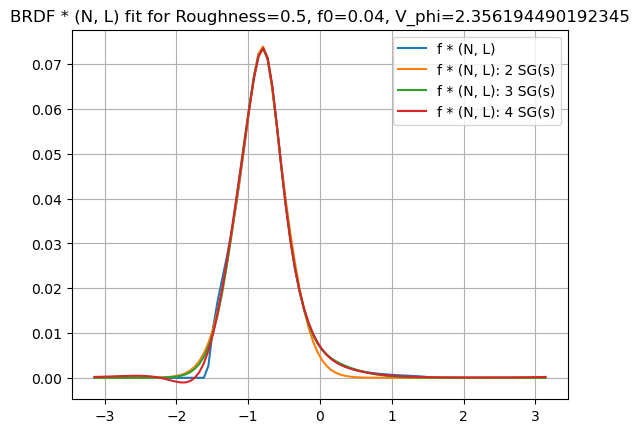

Fit 2 SG(s):
Optimal parameters:
[[5.50302662e-01 4.33978405e-03 8.15209970e+00]
 [1.64091275e+00 5.29775152e-03 2.21429411e+00]]
Sigma^2:
[[6.41010559e-04 1.54168101e-07 1.94381850e+00]
 [3.39781132e-03 2.78141781e-08 5.43560449e-02]]
Sigma:
[[2.53181863e-02 3.92642460e-04 1.39420892e+00]
 [5.82907481e-02 1.66775832e-04 2.33143829e-01]]
Epsilon:
[[0.04600775 0.09047511 0.17102452]
 [0.03552337 0.03148049 0.10529036]]

Fit 3 SG(s):
Optimal parameters:
[[ 1.75530292e+00  4.76229398e-03  2.34059130e+00]
 [ 5.35167795e-01  4.74831677e-03  4.17586961e+00]
 [-1.38419470e-01 -2.38758897e-03  3.58669080e+01]]
Sigma^2:
[[4.52324686e-03 5.77124718e-08 5.79673647e-02]
 [1.59542834e-03 1.20106681e-07 5.49158366e-01]
 [2.64463233e-04 1.08760351e-07 1.10109146e+02]]
Sigma:
[[6.72550880e-02 2.40234202e-04 2.40764127e-01]
 [3.99428134e-02 3.46564108e-04 7.41052202e-01]
 [1.62623256e-02 3.29788342e-04 1.04932905e+01]]
Epsilon:
[[0.03831537 0.05044506 0.10286466]
 [0.07463606 0.07298673 0.17746057]
 [0

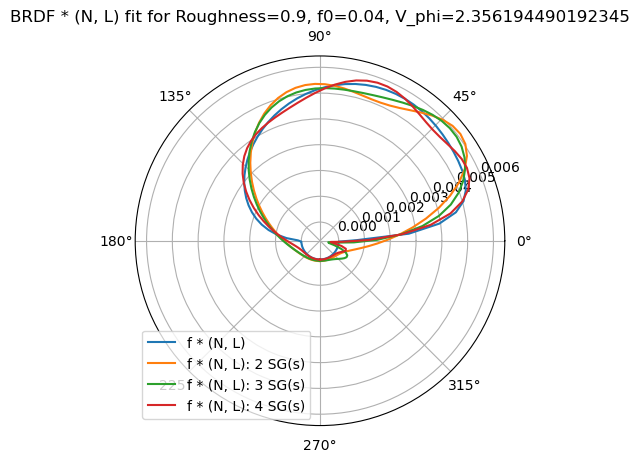

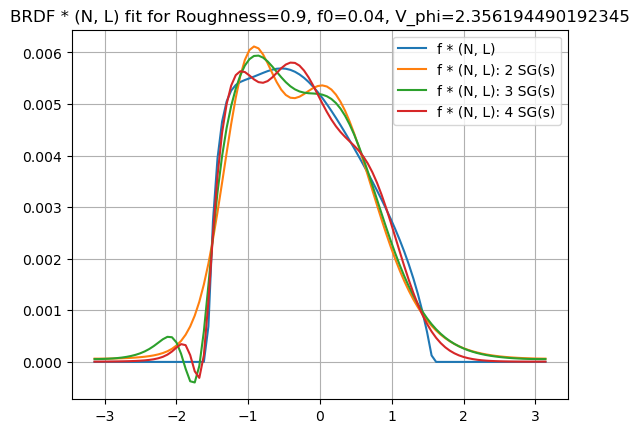

In [9]:
# Fit BRDF (N, L) SG

for roughness in (0.1, 0.5, 0.9):
    f0 = 0.04
    alpha = roughness ** 2
    alpha2 = alpha ** 2

    N_phi = np.pi / 2
    V_phi = 3 * np.pi / 4
    R_phi = 2 * N_phi - V_phi
    N = polar_to_r3(N_phi)
    V = polar_to_r3(V_phi)

    phi = np.linspace(-np.pi / 2, 3 * np.pi / 2, num=100)
    L = polar_to_r3(phi)
    f_NoL = BRDF(f0, alpha, N, V, L, mul_NoL=True)

    def eval_brdf_sg(phi, *args):
        args = np.array(args).reshape(-1, 3, 1)
        axis = args[:, 0]
        amp = args[:, 1]
        sh = args[:, 2]  
        return SG(polar_to_r3(axis, axis=1), np.expand_dims(amp, -1), np.expand_dims(sh, -1)).eval(polar_to_r3(phi))

    def jac_brdf_sg(phi, *args):
        v = polar_to_r3(phi)
        args = np.array(args).reshape(-1, 3, 1)

        axis = args[:, 0]
        amp = args[:, 1]
        sh = args[:, 2]
        u = polar_to_r3(axis, axis=1)
        sg = SG(u, np.expand_dims(amp, -1), np.expand_dims(sh, -1))
        
        du = polar_to_r3_diff(axis, axis=1)
        
        j = sg.jac(v)
        du = dot(du, j[:, :3], keepdims=True)
        j = np.concatenate((du, j[:, 3:]), axis=1)
        j = np.vstack(j).transpose()

        return j

    brdf_NoL_sgs = []

    MIN_SG = 2
    MAX_SG = 4

    for k in range(MIN_SG, MAX_SG + 1):
        try:
            p0 = np.tile((R_phi, 1 / (np.pi * alpha2 * k), 2 / alpha2), k)
            popt, pcov = sp.optimize.curve_fit(eval_brdf_sg, phi, f_NoL, p0=p0, jac=jac_brdf_sg, maxfev=10_000)
            print(f"Fit {k} SG(s):")
            print("Optimal parameters:\n{}".format(popt.reshape(-1, 3)))
            # print("CN: {}".format(np.linalg.cond(pcov)))
            sigma_2 = np.diag(pcov).reshape(-1, 3)
            sigma = np.sqrt(sigma_2)
            eps = np.abs(sigma / popt.reshape(-1, 3))
            print(f"Sigma^2:\n{sigma_2}")
            print(f"Sigma:\n{sigma}")
            print(f"Epsilon:\n{eps}")
            print("")
            brdf_NoL_sgs.append(popt)
        except RuntimeError:
            break

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    plt.title(f"BRDF * (N, L) fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
    ax.plot(phi, f_NoL, label="f * (N, L)")
    for k, brdf_NoL_sg in enumerate(brdf_NoL_sgs, start=MIN_SG):
        ax.plot(phi, eval_brdf_sg(phi, brdf_NoL_sg), label=f"f * (N, L): {k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"BRDF * (N, L) fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
    ax.plot(phi - np.pi / 2, f_NoL, label="f * (N, L)")
    for k, brdf_NoL_sg in enumerate(brdf_NoL_sgs, start=MIN_SG):
        ax.plot(phi - np.pi / 2, eval_brdf_sg(phi, brdf_NoL_sg), label=f"f * (N, L): {k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()